In [6]:
import sys, os
from pathlib import Path
# Ensure project root is on sys.path so `src` can be imported when running notebooks
proj_root = Path().resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from src.models import ResNet101Meta
import src.dataset as dataset
from src.train import train, plot_train_hist, set_seed_cuda
from src.evaluate import evaluate
from torch import nn
import torch

In [7]:
# Load and Preprocess Data
set_seed_cuda(42)
df = dataset.get_df("data/ISIC_2020_Training_GroundTruth.csv")
train_df, val_df, test_df = dataset.group_split_df(df)
train_transform, val_transform, test_transform = dataset.transforms(img_size=224)

train_ds = dataset.MelanomaDS(train_df, train_transform, use_meta=True, mode='Train')
val_ds   = dataset.MelanomaDS(val_df,   val_transform,   use_meta=True, mode='Train')
test_ds  = dataset.MelanomaDS(test_df,  test_transform,   use_meta=True, mode = 'Test')

sampler, pos_weight = dataset.sampler(train_df)
train_loader = dataset.DataLoader(train_ds, sampler=sampler, batch_size=64, shuffle=False, num_workers=4)
val_loader = dataset.DataLoader(val_ds, batch_size=64, num_workers=4)
test_loader = dataset.DataLoader(test_ds, batch_size=64, num_workers=4)

In [8]:
# Set up Model
net = ResNet101Meta(train_ds.meta.shape[1]).to(device = 'cuda')
# criterion = nn.BCEWithLogitsLoss() # without weighted loss
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight*0.4).to('cuda')) # with weighted loss
opt = torch.optim.AdamW([
    {"params": net.backbone.layer4.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.layer4.parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss_res, hist_val_loss_res, hist_val_acc_res = train(net, train_loader, val_loader, criterion, opt,
                                                     epochs = 2, best_model_name = "Best_Resnet101_meta.pt")

100%|██████████| 309/309 [05:54<00:00,  1.15s/it]



Saved new best model at epoch 1 with AUC=0.8260
Epoch 1: Loss Ratio=1.0620, Val AUC=0.8260, Val Pos Acc=0.9051


100%|██████████| 309/309 [06:09<00:00,  1.20s/it]



Epoch 2: Loss Ratio=1.4905, Val AUC=0.8212, Val Pos Acc=0.6788
Best validation pos_acc: 0.9051


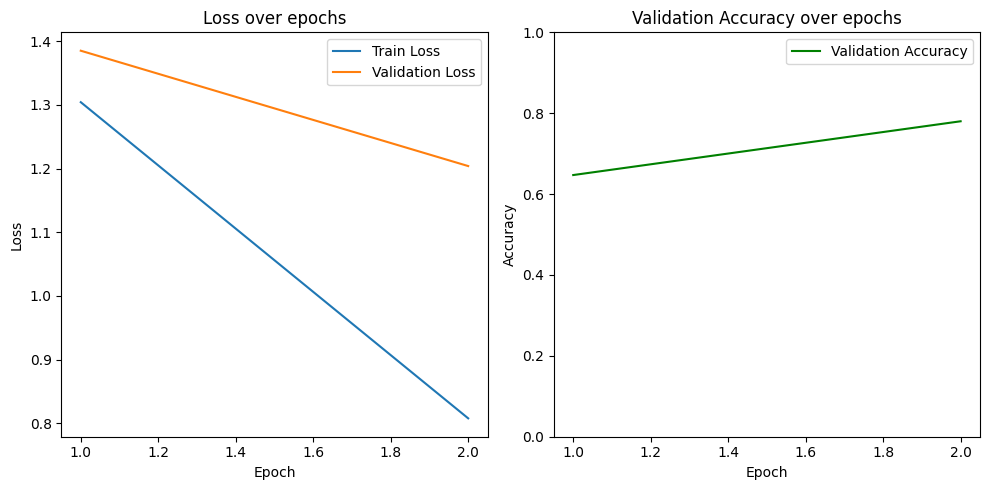

In [9]:
plot_train_hist(hist_train_loss_res, hist_val_loss_res, hist_val_acc_res, epochs = 2)

C:\Users\qyk\AppData\Local\Temp\ipykernel_18344\1816048424.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("Best_Resnet101_meta.pt", map_location

Test AUC: 0.8653 Test Accuracy: 0.7030


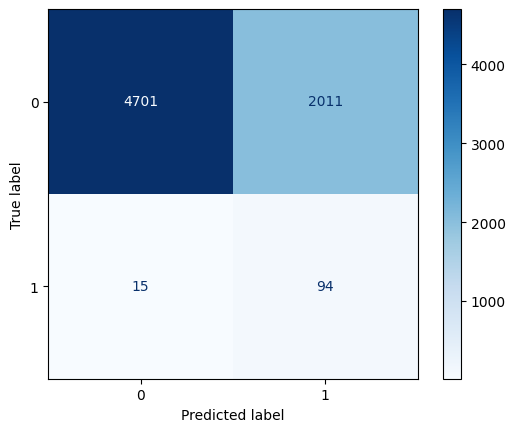

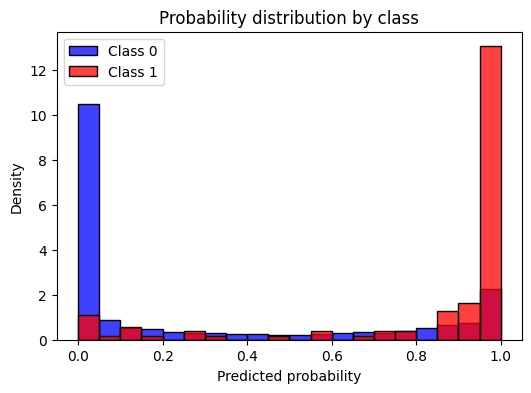

In [10]:
# Load Saved Model
state_dict = torch.load("Best_Resnet101_meta.pt", map_location='cuda')
net.load_state_dict(state_dict)

cm_res, ys_res, ps_res, idx_res = evaluate(net, test_loader, device = 'cuda', use_meta= True, threshold=0.5)

In [11]:
# # Load Kaggle Competition Winning Model
# # Find Model Here: https://www.kaggle.com/datasets/boliu0/melanoma-winning-models
# state_dict = torch.load("kaggle_WinningModel.pth", map_location='cuda')
# net.load_state_dict(state_dict)
#
# cm_res, ys_res, ps_res, idx_res = evaluate(net, test_loader, device = 'cuda', use_meta= True, threshold=0.5)

In [14]:
from src.models import Efficientnet_b6

In [15]:
# Set up Model
net = Efficientnet_b6(train_ds.meta.shape[1]).to(device = 'cuda')
criterion = nn.BCEWithLogitsLoss() # without weighted loss
opt = torch.optim.AdamW([
    {"params": net.backbone.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.features[-1].parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss_eff, hist_val_loss_eff, hist_val_acc_eff = train(net, train_loader, val_loader, criterion, opt,
                                                     epochs = 2, best_model_name = "Best_Efficient_net_B6.pt")

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to C:\Users\qyk/.cache\torch\hub\checkpoints\efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:02<00:00, 64.4MB/s] 

100%|██████████| 309/309 [13:01<00:00,  2.53s/it]



Saved new best model at epoch 1 with AUC=0.7832
Epoch 1: Loss Ratio=1.1994, Val AUC=0.7832, Val Pos Acc=0.8321


100%|██████████| 309/309 [13:45<00:00,  2.67s/it]



Epoch 2: Loss Ratio=1.4453, Val AUC=0.7933, Val Pos Acc=0.8321
Best validation pos_acc: 0.8321


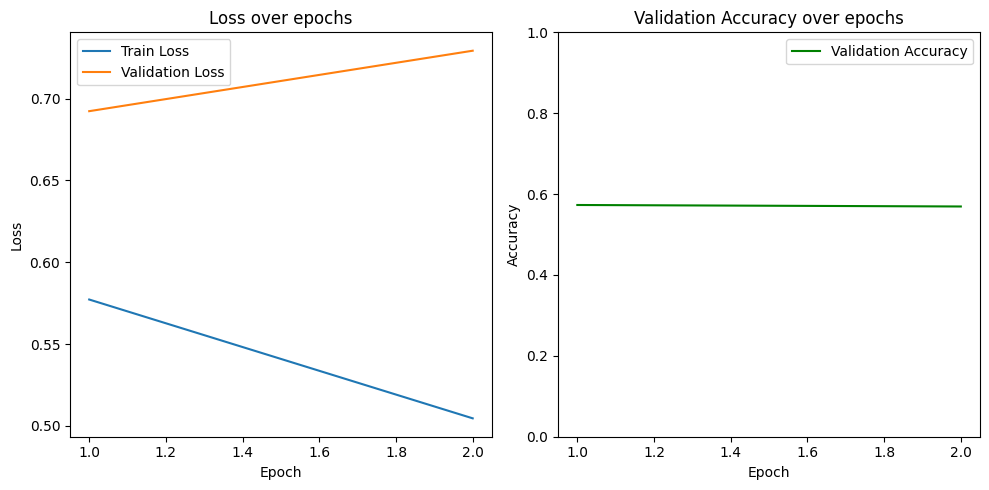

In [16]:
plot_train_hist(hist_train_loss_eff, hist_val_loss_eff, hist_val_acc_eff, epochs = 2)

C:\Users\qyk\AppData\Local\Temp\ipykernel_18344\41691796.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("Best_Efficient_net_B6.pt", map_location

Test AUC: 0.7874 Test Accuracy: 0.6204


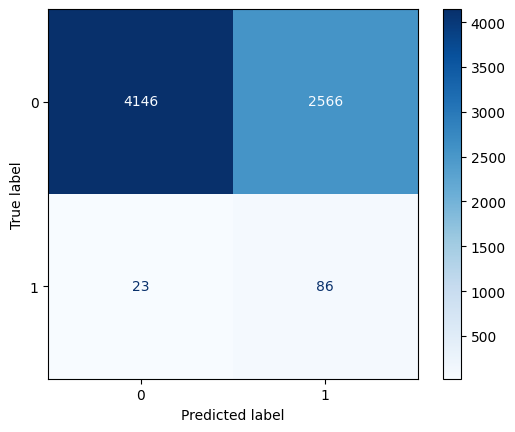

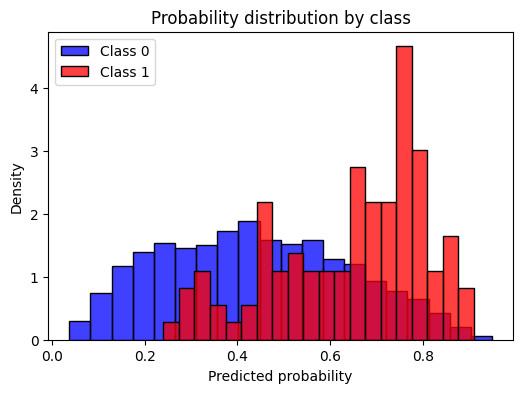

In [17]:
# Load Saved Model
state_dict = torch.load("Best_Efficient_net_B6.pt", map_location='cuda')
net.load_state_dict(state_dict)

cm_eff, ys_eff, ps_eff, idx_eff = evaluate(net, test_loader, device = 'cuda', use_meta= True, threshold=0.5)

In [ ]:
# Set up Model
net = Efficientnet_b6(train_ds.meta.shape[1]).to(device = 'cuda')
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight*0.4, dtype=torch.float32).to('cuda')) # with weighted loss
opt = torch.optim.AdamW([
    {"params": net.backbone.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.features[-1].parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss_eff2, hist_val_loss_eff2, hist_val_acc_eff2 = train(net, train_loader, val_loader, criterion, opt,
                                                     epochs = 2, best_model_name = "Best_Efficient_net_B6_2.pt")

100%|██████████| 309/309 [19:10<00:00,  3.72s/it]


Saved new best model at epoch 1 with AUC=0.7273
Epoch 1: Loss Ratio=0.3262, Val AUC=0.7273, Val Pos Acc=0.9562


100%|██████████| 309/309 [17:55<00:00,  3.48s/it]


Epoch 2: Loss Ratio=0.9742, Val AUC=0.7451, Val Pos Acc=0.9854
Best validation pos_acc: 0.9562


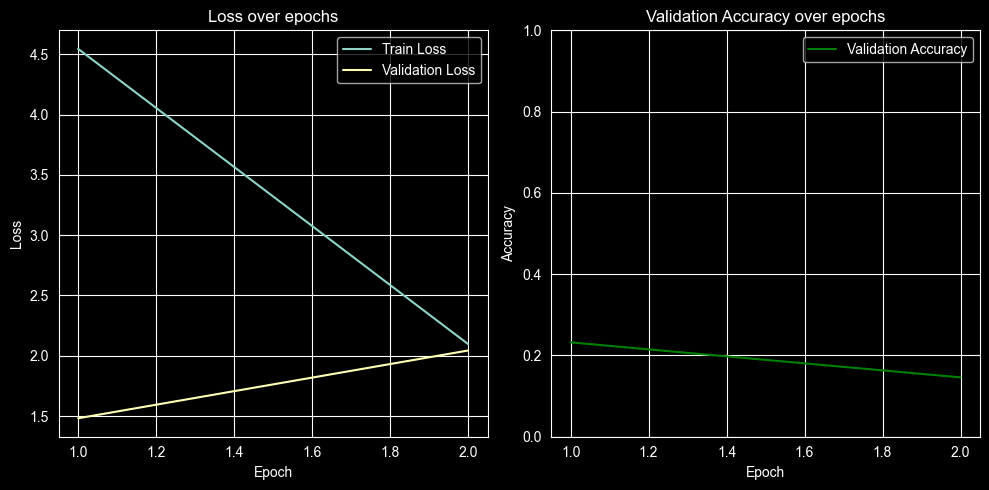

In [ ]:
plot_train_hist(hist_train_loss_eff2, hist_val_loss_eff2, hist_val_acc_eff2, epochs = 2)

100%|██████████| 107/107 [03:53<00:00,  2.19s/it]


Test AUC: 0.7595 Test Accuracy: 0.2456


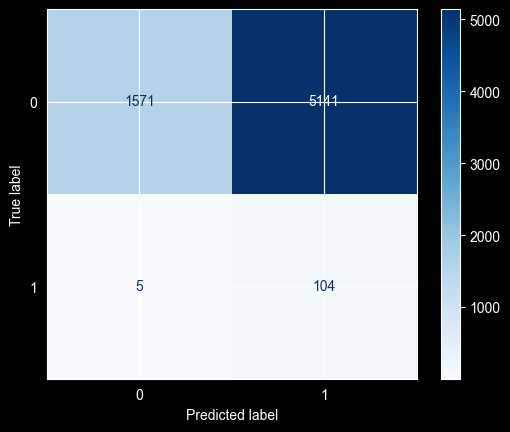

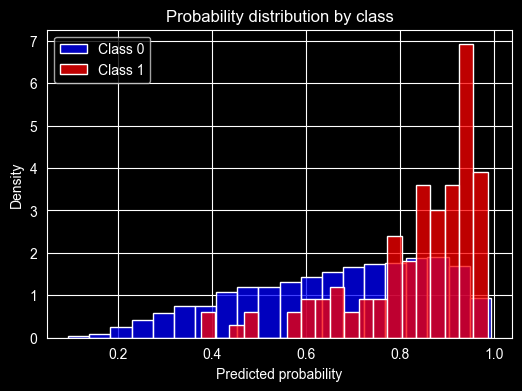

In [ ]:
# Load Saved Model
state_dict = torch.load("Best_Efficient_net_B6_2.pt", map_location='cuda')
net.load_state_dict(state_dict)

cm_eff2, ys_eff2, ps_eff2, idx_eff2 = evaluate(net, test_loader, device = 'cuda', use_meta= True, threshold=0.5)

In [ ]:
import numpy as np

In [ ]:
np.savez(
    "Evaluation_metrics.npz",

    # EfficientNet2
    hist_train_loss_eff2=hist_train_loss_eff2,
    hist_val_loss_eff2=hist_val_loss_eff2,
    hist_val_acc_eff2=hist_val_acc_eff2,

    # ResNet
    hist_train_loss_res=hist_train_loss_res,
    hist_val_loss_res=hist_val_loss_res,
    hist_val_acc_res=hist_val_acc_res,

    # EfficientNet
    hist_train_loss_eff=hist_train_loss_eff,
    hist_val_loss_eff=hist_val_loss_eff,
    hist_val_acc_eff=hist_val_acc_eff,


    cm_eff2=cm_eff2,
    ys_eff2=ys_eff2,
    ps_eff2=ps_eff2,
    idx_eff2=idx_eff2,


    cm_res=cm_res,
    ys_res=ys_res,
    ps_res=ps_res,
    idx_res=idx_res,

    cm_eff=cm_eff,
    ys_eff=ys_eff,
    ps_eff=ps_eff,
    idx_eff=idx_eff
)

In [ ]:
net

In [ ]:
data = np.load("Evaluation_Metrics.npz", allow_pickle=True)